import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [162]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from utils.metrics import *
#from utils.flow_functions import *
#from models.pem import *
#from models.PEM_compact import *
#from fetchData.datasetCOMBINED import *
#from trainingProtocol.trainval_COM2s_intFlow_LazyPrior_bidirection import *
#from trainingProtocol.trainval_COM2s_intFlow_sLazyPrior_bidirectionAllLayers import *
#from losses import *
#from losses_suppl import *

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

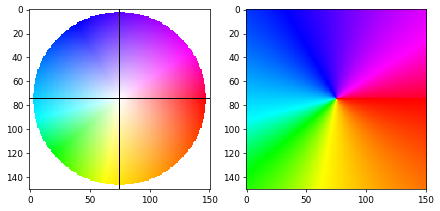

In [200]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())

figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChart)

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)

#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [297]:
path_to_imdb = '/home/skong2/restore/dataset/BCI_pollenDetClsSystem_dataset/imdb_files/imdb_segDet.mat'
mat = scipy.io.loadmat(path_to_imdb)
mat = mat['imdb'][0][0]
func = transforms.ToTensor()

In [298]:
randNumList = mat[0][0] # [1×16425 double]
slideNumList = mat[1][0] # [1×16425 double]
absXList = mat[2][0] #: [1×16425 double]
absYList = mat[3][0] #: [1×16425 double]
annotPollenNumList = mat[4][0] #: [1×16425 double]
relativeXList = mat[5][0] #: [1×16425 double]
relativeYList = mat[6][0] #: [1×16425 double]
zPlaneList = mat[7][0] #: [1×16425 double]
radiusList = mat[8][0] #: [1×16425 double]
confList = mat[9][0] #: [1×16425 double]
labelNameList = mat[10][0] #: {1×16425 cell}
className = mat[11][0] #: {1×131 cell}
classMapping_Name2Label = mat[12][0] #: [131×1 containers.Map]
labelList = mat[13][0] #: [1×16425 double]
imgpathList = mat[14][0] #: {1×16425 cell}
path_to_mask = mat[15][0] #: '/home/skong2/pollenProject_dataset_mask'
path_to_image = mat[16][0] #: '/home/skong2/pollenProject_dataset'
imgList = mat[17][0] #: {1×16425 cell}
maskList = mat[18][0] #: {1×16425 cell}

In [299]:
idx = 19 # 1 19

relX = int(relativeXList[idx])
relY = int(relativeYList[idx])
radius = radiusList[idx]
filename_image = imgList[idx][0].replace('pollenProject_dataset','restore/dataset/pollenProject_dataset_part1')
filename_label = maskList[idx][0].replace('pollenProject_dataset_mask','restore/dataset/pollenProject_dataset_mask')
print(filename_image)
print(filename_label)

image = PIL.Image.open(filename_image)
label = PIL.Image.open(filename_label)
image = np.array(image)
label = np.array(label)
#image = func(image)
#label = func(label)

mask_distanceTransform = ndimage.distance_transform_edt(label)
print(mask_distanceTransform.max())
coord_peaks = feature.peak_local_max(mask_distanceTransform, min_distance=10)
mask_peaks = label*0.
mask_radius = label*0.
mask_voteX = label*0.
mask_voteY = label*0.
mask_overlap = label*0.
r_list = []
annot = dict()
annot['size'] = label.shape
for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    r = mask_distanceTransform[y, x]
    r_list += [r]
    #mask_peaks[y-10:y+10, x-10:x+10] = 1
    #mask_radius[y-10:y+10, x-10:x+10] = r
    mask_peaks[y, x] = 1
    mask_radius[y, x] = r
    
    #tmpmask_vote = np.zeros((image.shape[0], image.shape[1]))
    mask_x, mask_y = np.asarray(range(image.shape[1])).astype(np.float), np.asarray(range(image.shape[0])).astype(np.float)
    mask_x, mask_y = np.meshgrid(mask_x, mask_y)
    mask_x = float(x) - mask_x
    mask_y = float(y) - mask_y
    
    tmpmask_vote = mask_x*mask_x + mask_y*mask_y <= r*r
    mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
    mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
    mask_overlap += tmpmask_vote.astype(np.float)
mask_overlap = mask_overlap>1
mask_overlap = mask_overlap.astype(np.uint8)    



# annotMat['peak'] = mask_peaks.astype(np.bool)
# annotMat['segm'] = label.astype(np.bool)
# annotMat['distTransform'] = mask_distanceTransform
# annotMat['radius'] = mask_radius
# annotMat['segm'] = label.astype(np.bool)
# annotMat['overlap'] = mask_overlap.astype(np.bool)
# annotMat['mask_voteX'] = mask_voteX
# annotMat['mask_voteY'] = mask_voteY

annot['coord_peaks'] = coord_peaks
annot['mask_radius'] = r_list

with open('test.plk', 'wb') as handle:
    pickle.dump(annot, handle) # , protocol=pickle.HIGHEST_PROTOCOL

/home/skong2/restore/dataset/pollenProject_dataset_part1/cec/89.1994-1994-15-35.16.3.23000.11000.png
/home/skong2/restore/dataset/pollenProject_dataset_mask/cec/89.1994-1994-15-35.16.3.23000.11000.bmp
46.87216658103186


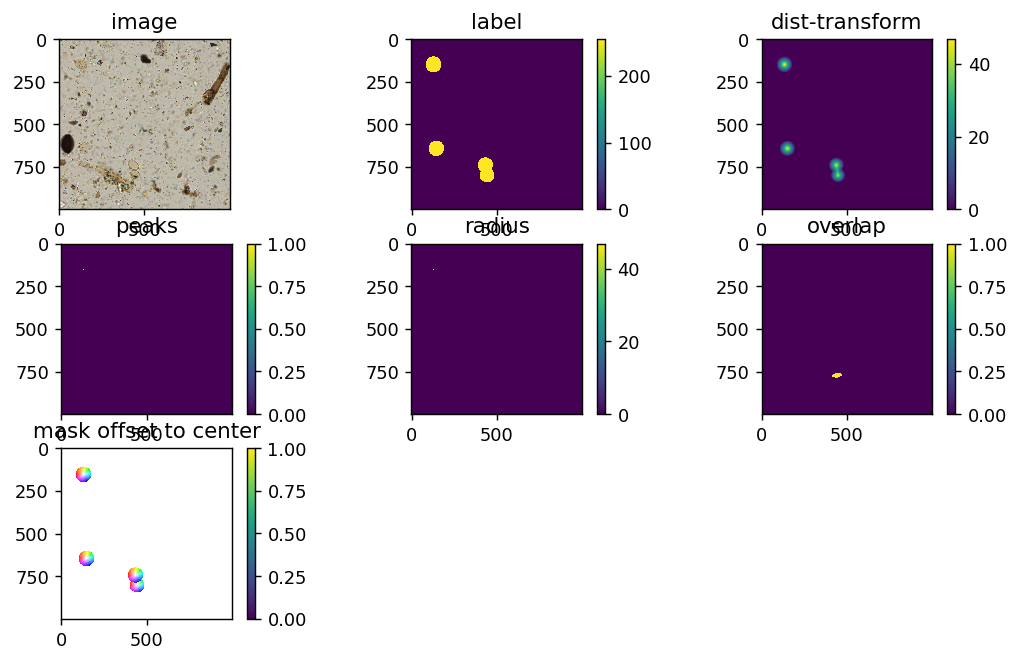

In [300]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 3
plt.figure(figsize=(10, 6), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(label)
#plt.axis('off')
plt.title('label')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_distanceTransform)
#plt.axis('off')
plt.title('dist-transform')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_peaks)
#plt.axis('off')
plt.title('peaks')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_radius)
#plt.axis('off')
plt.title('radius')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_overlap)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow = objDemoShowFlow.computeColor(
    mask_voteX/np.abs(mask_voteX).max(), 
    mask_voteY/np.abs(mask_voteY).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('mask offset to center')
plt.colorbar()

In [295]:
with open('test.plk', 'rb') as handle:
    annot = pickle.load(handle)

label = np.zeros((annot['size'][0], annot['size'][1]))

mask_distanceTransform = label*0.
mask_peaks = label*0.
mask_radius = label*0.
mask_voteX = label*0.
mask_voteY = label*0.
mask_overlap = label*0.
for i in range(annot['coord_peaks'].shape[0]):
    y, x = annot['coord_peaks'][i]
    r = annot['mask_radius'][i]
    
    mask_peaks[y-10:y+10, x-10:x+10] = 1
    mask_radius[y-10:y+10, x-10:x+10] = r
    #mask_peaks[y, x] = 1
    #mask_radius[y, x] = r
    
    mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
    mask_x, mask_y = np.meshgrid(mask_x, mask_y)
    mask_x = float(x) - mask_x
    mask_y = float(y) - mask_y
    
    tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
    tmpmask_vote = tmpDistTransform <= r
    label[tmpmask_vote] = 1
    mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
    mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
    mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]
    mask_overlap += tmpmask_vote.astype(np.float)
mask_overlap = mask_overlap>1
mask_overlap = mask_overlap.astype(np.uint8)    


# annotMat['peak'] = mask_peaks.astype(np.bool)
# annotMat['segm'] = label.astype(np.bool)
# annotMat['distTransform'] = mask_distanceTransform
# annotMat['radius'] = mask_radius
# annotMat['segm'] = label.astype(np.bool)
# annotMat['overlap'] = mask_overlap.astype(np.bool)
# annotMat['mask_voteX'] = mask_voteX
# annotMat['mask_voteY'] = mask_voteY

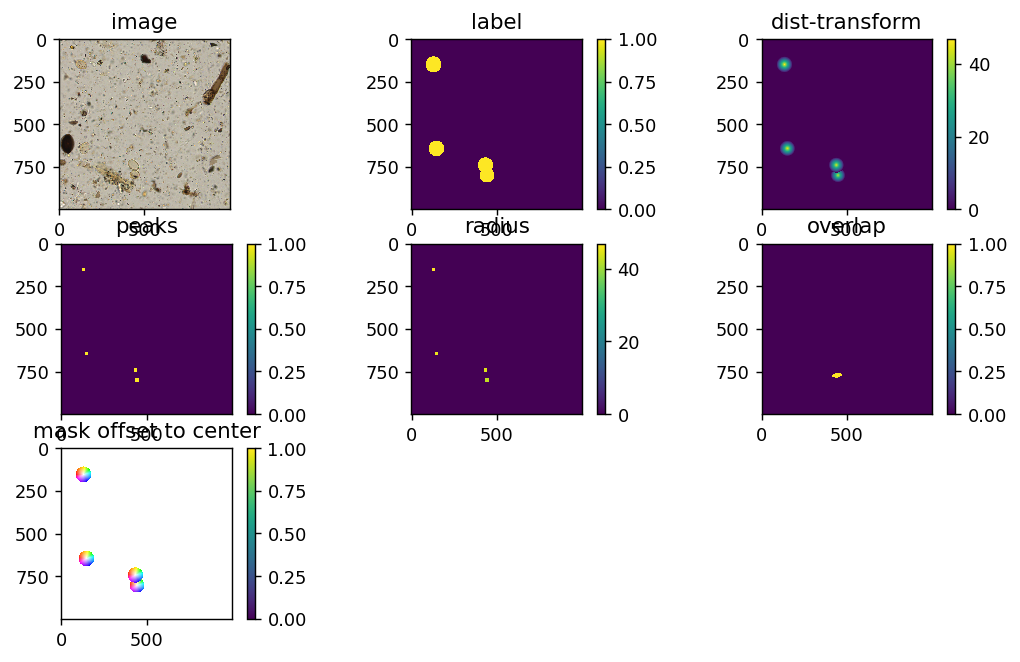

In [296]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 3
plt.figure(figsize=(10, 6), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(label)
#plt.axis('off')
plt.title('label')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_distanceTransform)
#plt.axis('off')
plt.title('dist-transform')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_peaks)
#plt.axis('off')
plt.title('peaks')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_radius)
#plt.axis('off')
plt.title('radius')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_overlap)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow = objDemoShowFlow.computeColor(
    mask_voteX/np.abs(mask_voteX).max(), 
    mask_voteY/np.abs(mask_voteY).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('mask offset to center')
plt.colorbar()

In [14]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_label = '/home/skong2/restore/dataset/pollenProject_dataset_mask'

In [31]:
labelIdx = []
samplePathList = []
labelNameList = []
labelIDxList = []
labelIdxCount = 0
dict_classCount = dict()
for subfolder in os.listdir(path_to_image):            
    set_path = []
    tmpSampleList = os.listdir(path.join(path_to_image, subfolder))# self.sorted_dir
    if len(tmpSampleList)>1:
        dict_classCount[subfolder] = len(tmpSampleList)
        for sampleFile in tmpSampleList: # self.sorted_dir
            if sampleFile.endswith((".png","_files")): 
                samplePathList += [path.join(subfolder, sampleFile[:-4])]
                labelNameList += [subfolder]
                labelIDxList += [labelIdxCount] 
        labelIdxCount += 1

In [38]:
count=0
for key in dict_classCount:
    if dict_classCount[key]>15:
        count += 1
        print(count, key, dict_classCount[key])

1 mor 1551
2 ant 36
3 tch 69
4 mic 194
5 cec 1099
6 gus 47
7 hyr 410
8 trm 235
9 lue 57
10 lae 32
11 lyc 183
12 oen 82
13 pip 121
14 ply 89
15 euc 19
16 qua 56
17 als 140
18 alc 77
19 sim 118
20 ape 16
21 fic 101
22 ind 382
23 cel 34
24 cas 94
25 abe 27
26 zna 161
27 hir 33
28 arb 19
29 znb 34
30 cor 50
31 spa 40
32 ast 17
33 sol 36
34 cyn 34
35 byr 18
36 poa 40
37 unc 23
38 prt 24
39 fra 33
40 vir 52
41 pob 18


In [47]:
samplename = 'abe/11.1995-1996-15-25.35.-15.14000.21000'
samplename = 'abe/11.1995-1996-15-25.41.-19.42000.17000'
samplename = 'abe/11.1995-1996-15-25.35.-15.14000.21000'
samplename = 'abe/123.1995-1996-10-40.76.-20.17000.12000'


filename_image = os.path.join(path_to_image, samplename+'.png')
filename_label = os.path.join(path_to_label, samplename+'.bmp')

image = PIL.Image.open(filename_image)
label = PIL.Image.open(filename_label)

In [48]:
func = transforms.ToTensor()
image = func(image)
label = func(label)
image = image.unsqueeze(0)
label = label.unsqueeze(0)

In [49]:
label.shape, image.shape

(torch.Size([1, 1, 1000, 1000]), torch.Size([1, 3, 1000, 1000]))

In [50]:
image.max(), image.min(), label.max(), label.min()

(tensor(1.), tensor(0.0392), tensor(1.), tensor(0.))

In [51]:
height = 512
width = 512
image = F.interpolate(image, size=(height, width), mode='bilinear', align_corners=True)
label = F.interpolate(label, size=(height, width), mode='nearest')

In [52]:
image.shape, label.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 1, 512, 512]))

In [ ]:
image = np.array(image)
label = np.array(label)

Text(0.5, 1.0, 'label')

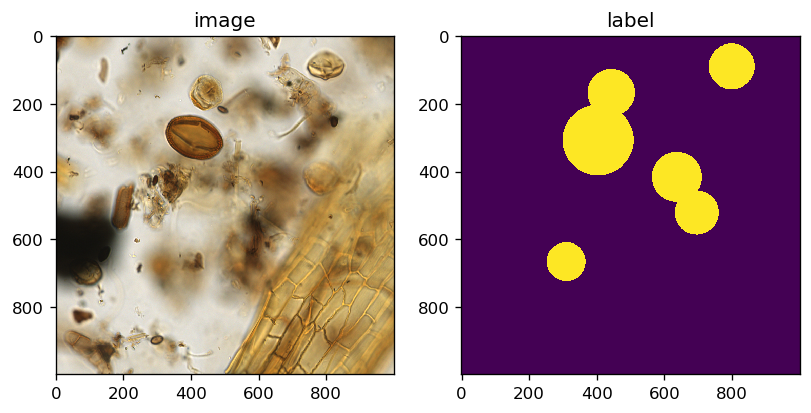

In [28]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = numSample2Show, 2
plt.figure(figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(label)
#plt.axis('off')
plt.title('label')

In [54]:
class PollenDet(Dataset):
    def __init__(self, path_to_image='/home/skong2/restore/dataset/pollenProject_dataset_part1',
                 path_to_label='/home/skong2/restore/dataset/pollenProject_dataset_mask',
                 size=[512, 512], 
                 set_name='train', 
                 TFNormalize=None):
        self.path_to_image = path_to_image
        self.path_to_label = path_to_label
        self.transform = transform
        self.set_name = set_name        
        self.current_set_len = 0 #len(os.listdir(self.current_set_dir))        
        self.size = size
        self.labelName = []
        self.labelIdx = []
        self.samplePath = []
        self.TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        
        labelIdxCount = 0
        for subfolder in os.listdir(self.path_to_image):            
            set_path = []            
            for sampleFile in os.listdir(path.join(self.path_to_image, subfolder)): # self.sorted_dir
                if sampleFile.endswith((".png","_files")): 
                    self.samplePath += [path.join(subfolder, sampleFile[:-4])]
                    self.labelName += [subfolder]
                    self.labelIdx += [labelIdxCount] 
            labelIdxCount += 1            
        
        self.current_set_len = len(self.samplePath)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()        
        self.TFNormalize = TFNormalize # transforms.Normalize((127.,127.,127.),(127.,127.,127.))        
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        filename_image = path.join(self.path_to_image, subfolder, sampleFile[:-4]+'.png')
        filename_label = path.join(self.path_to_label, subfolder, sampleFile[:-4]+'.bmp')
        
        image = PIL.Image.open(filename_image)
        #image = self.tmpTFresize(image)
        label = PIL.Image.open(filename_label)
        #label = self.tmpTFresize(lable)
        
        if self.set_name=='train' and np.random.random(1)>0.5:
            image = image.transpose(PIL.Image.FLIP_TOP_BOTTOM)
            label = label.transpose(PIL.Image.FLIP_TOP_BOTTOM)
        if self.set_name=='train' and np.random.random(1)>0.5:
            image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            label = label.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            
        image = self.TF2tensor(image)
        label = self.TF2tensor(label)
        image = image.unsqueeze(0)
        label = label.unsqueeze(0)
        
        image = F.interpolate(image, size=(self.size[0],self.size[1]), mode='bilinear', align_corners=True)
        label = F.interpolate(label, size=(self.size[0], self.size[1]), mode='nearest')
        image = image.squeeze(0)
        image = self.TFNormalize(image)
        label = label.squeeze(0)
        return image, label       

setup dataset
-----------

In [3]:
################## dataset ###################
TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

whole_datasets = {set_name: COMBINEDframepair(dbDirList=path_to_root,  
                                              set_name=set_name, 
                                              downsizeFactorList=downsizeFactorList,
                                              size=cropSize, # if set_name=='train' else [-1,-1],
                                              TFNormalize=TFNormalize)
                  for set_name in ['train', 'val']}



dataloaders = {set_name: DataLoader(whole_datasets[set_name], 
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'val']}

dataset_sizes = {set_name: len(whole_datasets[set_name]) for set_name in ['train', 'val']}
print(dataset_sizes)
#10024+29308+1523*2

{'train': 3046, 'val': 196}




Leaving Blank
-----